# 2. Decentralized Optimizaiton

## 2.1 Network topologies

To run decentralized algorithms, we have to set up the network topology. 

In [1]:
import os
import scipy.io as sio
import networkx as nx   # nx will be used for network topology creating and plotting
from bluefog.common import topology_util
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# You can change NUM_PROC into any value smaller than the number of CPUs you have.
import os
NUM_PROC = 4 if os.getenv("TEST_ENV") else 8
NUM_PROC

### 2.1.1 Ring topology

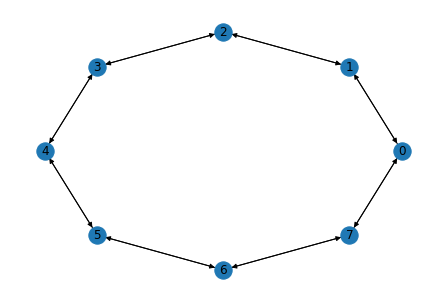

In [6]:
network_size = 8
G = topology_util.RingGraph(network_size)
labels={i: i for i in range(network_size)}
nx.draw_circular(G, labels=labels)

### 2.1.2 Mesh Grid topology

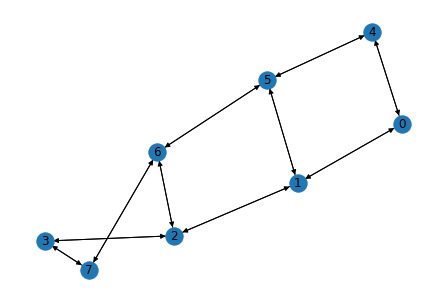

In [11]:
network_size = 8
G = topology_util.MeshGrid2DGraph(network_size)
labels={i: i for i in range(network_size)}
nx.draw_spring(G, labels=labels)

### 2.1.3 Exponential-two topology

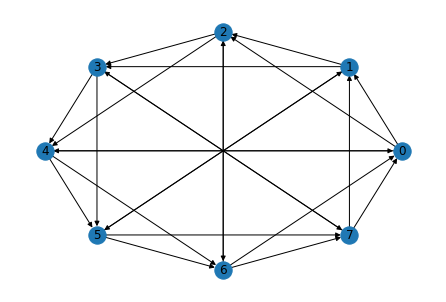

In [15]:
network_size = 8
G = topology_util.ExponentialTwoGraph(network_size)
labels={i: i for i in range(network_size)}
nx.draw_circular(G, labels=labels)

## 2.2 Decentralized ADMM

Continue on the centralized ADMM algorithm. We consider the same consensus problem:
$$
    \min_{x} \sum_{i=1}^n h_i(x)
$$
Instead of relaxing $x$ into $\{x_i\}$ and forcing them to be the common value $y$, we can map it into a graph structure. More percisely, assigning $h_i$ into each vertex and relaxing the common $x$ by $\{x_i\}$ owned by each vertex. The constraint of $x_i = x_j$ can be transfered into constrain on the edge:

\begin{align}
    \min_{\{x_i\}_{i\in V},\; \{y_e\}_{e\in E} }&\;\; \sum_{i=1}^n h_i(x_i)\\
    {\rm subject\ to} &\;\; x_i - y_e=0,\;  x_j - y_e=0, \;\;\forall e=\{i,j\} \in E
\end{align}

As long as the graph is connected, it is easy to see it is equivalent to original consenus problem.

To solve this, we consider the augmented Lagrangian and the dual variables $u_{e,i}$ for $x_i - y_e=0$ and $u_{e,j}$ for $x_j - y_e=0$. After applying the ADMM algorithm and simplifying, we obtain

\begin{align}
    x_{i}^{k+1} =& {\rm Prox}_{(\alpha |N_i|)^{-1} h_i} (v_i^k)\\
    a_{i}^{k+1} =& \frac{1}{2|N_i|} \sum_{j\in N_i} x_j^{k+1}\\
    v_{i}^{k+1} =& v_{i}^{k} + a_{i}^{k+1} - (a_{i}^{k} + x_{i}^{k})/2
\end{align}

The code snippet:
```python
bf.set_topology(topology_util.RingGraph(bf.size()))

def DecentralizedADMMStepL2(A, b, x, a, v, n_i, alpha):
    next_x = ProximalStepL2(A, b, v, n_i, alpha)
    # `bf.in_neighbor_ranks()` loads all incoming neighbor ranks of the topology in `bf.set_topology()`
    neighbor_weights = {r: 1.0 / n_i for r in bf.in_neighbor_ranks()}
    next_a = bf.neighbor_allreduce(
        next_x, self_weight=0.0, neighbor_weights=neighbor_weights
    )   # <-- this is the key difference. Changing from allreduce to neighbor_allreduce
    next_v = v + next_a - (x + a) / 2
    return next_x, next_a, next_v
```

In [16]:
! bfrun -np $NUM_PROC python DecentralizedADMM.py

[Decentralized ADMM] Allreduce residue gradient norm: 1.1404968325674104e-15
[Decentralized ADMM] Rank 1: ADMM residue gradient norm: 1.6168195861154377e-14
[Decentralized ADMM] Rank 0: ADMM residue gradient norm: 1.6168195861154377e-14
[Decentralized ADMM] Rank 2: ADMM residue gradient norm: 1.6168195861154377e-14
[Decentralized ADMM] Rank 3: ADMM residue gradient norm: 1.6168195861154377e-14
Last three entries of x_ar:
 tensor([[0.6872],
        [0.6552],
        [0.8751]], dtype=torch.float64)
Last three entries of x_admm:
 tensor([[0.6872],
        [0.6552],
        [0.8751]], dtype=torch.float64)


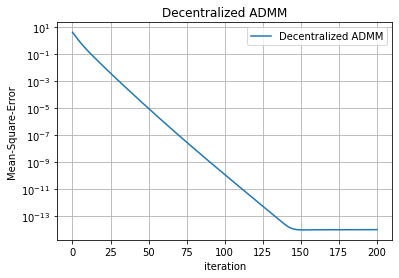

In [17]:
mse_records_dict = sio.loadmat('results/DecentralizedADMM.mat')

plt.semilogy(mse_records_dict["mse"][0], label="Decentralized ADMM")
plt.title("Decentralized ADMM")
plt.xlabel("iteration")
plt.ylabel("Mean-Square-Error")
plt.grid("on")
plt.legend()
dirname = 'images'
if not os.path.exists(dirname):
    os.makedirs(dirname)
plt.savefig(os.path.join(dirname, 'decentralized_admm.png'))

## 2.3 Mixing matrix

For commonly used undirected network, BlueFog provides the mixing matrix generated through the Metropolis–Hastings rule. 

> **Metropolis-Hastings rule.** Providing a undirected and connected topology $\mathcal{G}$, we select $w_{ij}$ as
> 
>\begin{align}
\hspace{-3mm}	w_{ij}=
	\begin{cases}
		\begin{array}{ll}\displaystyle
			\hspace{-2mm}\frac{1}{1 + \max\{d_i, d_j \}},& \mbox{if $j \in \mathcal{N}(i)$}, \\
			\hspace{-2mm}\displaystyle 1 - \sum_{j\in \mathcal{N}(i)}w_{ij}, & \mbox{if $i = j$},\\
			\hspace{-2mm}0,& \mbox{if $j \notin \mathcal{N}(i)$  and $j\neq i$}.
		\end{array}
	\end{cases}
\end{align}
>
> where $d_i = |\mathcal{N}(i)|$ (the number of incoming neighbors of agent $k$). It is easy to verify such $W$ is always doubly-stochastic.

### 2.3.1 Mixing matrix for the ring

The following code is to fetch mixing matrix provided by BlueFog.

```python
def FetchRingMixingMatrix(network_size):
    G = topology_util.RingGraph(network_size)   # organize nodes into a ring
    W = np.zeros((network_size, network_size))  # genearate an empty mixing matrix 

    for rank in range(network_size):
        self_weight, neighbor_weights = topology_util.GetRecvWeights(G, rank)  # fetch weights
        W[rank,rank] = self_weight              # put weights into the mixing matrix
        for r, v in neighbor_weights.items():
            W[rank, r] = v
            
    return W
```

In [18]:
! bfrun -np $NUM_PROC python Ring_mixingMatrix.py

[[0.333 0.333 0.    0.    0.    0.    0.    0.333]
 [0.333 0.333 0.333 0.    0.    0.    0.    0.   ]
 [0.    0.333 0.333 0.333 0.    0.    0.    0.   ]
 [0.    0.    0.333 0.333 0.333 0.    0.    0.   ]
 [0.    0.    0.    0.333 0.333 0.333 0.    0.   ]
 [0.    0.    0.    0.    0.333 0.333 0.333 0.   ]
 [0.    0.    0.    0.    0.    0.333 0.333 0.333]
 [0.333 0.    0.    0.    0.    0.    0.333 0.333]]

The sum of each col is: [1. 1. 1. 1. 1. 1. 1. 1.]
The sum of each row is: [1. 1. 1. 1. 1. 1. 1. 1.]
W is doubly stochastic.
The second largest eigenvalue is: 0.804737854124365


### 2.3.2 Mixing matrix for the Mesh

In [19]:
! bfrun -np $NUM_PROC python Mesh_mixingMatrix.py

[[0.417 0.25  0.    0.    0.333 0.    0.    0.   ]
 [0.25  0.25  0.25  0.    0.    0.25  0.    0.   ]
 [0.    0.25  0.25  0.25  0.    0.    0.25  0.   ]
 [0.    0.    0.25  0.417 0.    0.    0.    0.333]
 [0.333 0.    0.    0.    0.417 0.25  0.    0.   ]
 [0.    0.25  0.    0.    0.25  0.25  0.25  0.   ]
 [0.    0.    0.25  0.    0.    0.25  0.25  0.25 ]
 [0.    0.    0.    0.333 0.    0.    0.25  0.417]]

The sum of each col is: [1. 1. 1. 1. 1. 1. 1. 1.]
The sum of each row is: [1. 1. 1. 1. 1. 1. 1. 1.]
W is doubly stochastic.
The second largest eigenvalue is: 0.8535533905932756


### 2.3.3 Mixing matrix for Exponential-two Graph

In the exponential-two graph, each node has the same incoming degree and outgoing degree. Exponential-two graph is a directed graph, BlueFog provides a mixing matrix following averaging rule for Exponential-two graph.

> **Averaging rule.** Providing an exponential-two topology $\mathcal{G}$, we select $w_{ij}$ as
> 
>\begin{align}
\hspace{-3mm}	w_{ij}=
	\begin{cases}
		\begin{array}{ll}\displaystyle
			\hspace{-2mm}\frac{1}{1 + d},& \mbox{if $j \in \mathcal{N}_{\rm in}(i)$ or if $i = j$} , \\
			0,& \mbox{otherwise}.
		\end{array}
	\end{cases}
\end{align}
>
> where $d = |\mathcal{N}_{\rm in}(i)|$ (the number of incoming neighbors of agent $i$). It is easy to verify such $W$ is always doubly-stochastic because incoming degree $d$ of each node is the same.

Since Exponential-two Graph is a regular graph, such mixing matrix is doubly stochastic but not symmetric.

In [20]:
! bfrun -np $NUM_PROC python Exp2_mixingMatrix.py

[[0.25 0.   0.   0.   0.25 0.   0.25 0.25]
 [0.25 0.25 0.   0.   0.   0.25 0.   0.25]
 [0.25 0.25 0.25 0.   0.   0.   0.25 0.  ]
 [0.   0.25 0.25 0.25 0.   0.   0.   0.25]
 [0.25 0.   0.25 0.25 0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.25 0.25 0.25 0.   0.  ]
 [0.   0.   0.25 0.   0.25 0.25 0.25 0.  ]
 [0.   0.   0.   0.25 0.   0.25 0.25 0.25]]

The sum of each col is: [1. 1. 1. 1. 1. 1. 1. 1.]
The sum of each row is: [1. 1. 1. 1. 1. 1. 1. 1.]
W is doubly stochastic.
The second largest eigenvalue is: 0.5000000000000003


### 2.3.4 Commonly-used topology summary

The following table summarizes the second largest eigenvalue and the maximum degree of some common network topologes. The mixing matrix of the undirected topologies, i.e., the ring, 2D-mesh, and fully-connected topology, are generated through the Matropolis-Hastings  rule, while the mixing matrix of exponential-2 topology (which is a directed network) is genereted through the Averaging rule. 


| Network topology | second largest eigenvalue | maximum degree |
| -: | :-: | :-: |
| Undirected Ring | $1-O(\frac{1}{n^2})$ | 2 |
| Undirected 2D-Mesh | $1-O(\frac{1}{n})$ | 4 |
| Exponential-2 | $1-O(\frac{1}{\ln(n)})$ | $\ln(n)$ |
| Fully connected| $0$ |$n-1$ |  

## 2.4 Average consensus

Given the mixing matrix, the average consensus algorithm is:

$$x_i^{k+1} = \sum_{j \in \mathcal{N}_i \cup \{i\}} w_{ij} x_j^{k}$$

It is guaranteed that $ \frac{1}{n}\sum_{i=1}^n \|x_i^k - \frac{1}{n}\sum_{i=1}^n x_i^0\|^2 \le C \rho^{2k}$, where $\rho$ is the second largest eigenvalue of the matrix $W$. Apparently, $\rho$ decides the convergence rate of the average consensus algorithm. One step of average consensus can be conducted as

```python
G = topology_util.RingGraph(bf.size())  # set up the topology
bf.set_topology(G, is_weighted=True)    # organize nodes into the topology
# one-step average consensus
def avg_consensus_one_step(x):
    x_next = bf.neighbor_allreduce(x)
    return x_next
```

In [23]:
! bfrun -np $NUM_PROC python AverageConsensus.py

Runing average consensus with topology Ring
Progress 0/60
Progress 10/60
Progress 20/60
Progress 30/60
Progress 40/60
Progress 50/60
Runing average consensus with topology Mesh
Progress 0/60
Progress 10/60
Progress 20/60
Progress 30/60
Progress 40/60
Progress 50/60
Runing average consensus with topology Exp2
Progress 0/60
Progress 10/60
Progress 20/60
Progress 30/60
Progress 40/60
Progress 50/60


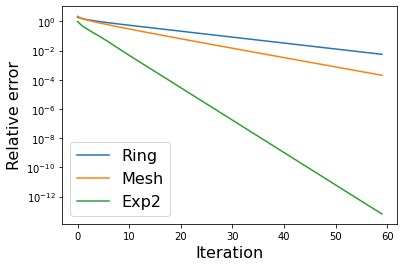

In [24]:
rel_error_dict = sio.loadmat('results/AverageConsensus.mat')
for graph in ['Ring', 'Mesh', 'Exp2']:
    record = rel_error_dict[graph].reshape(-1)
    plt.semilogy(record)
plt.legend(['Ring', 'Mesh', 'Exp2'], fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)
dirname = 'images'
if not os.path.exists(dirname):
    os.makedirs(dirname)
plt.savefig(os.path.join(dirname, 'AverageConsensus.png'))

The above figure depicts the influence of $\rho$. 

## 2.5 Decentralized gradient descent

Recall the optimization problem:

\begin{align*}
\min_{x\in \mathbb{R}^d}\ \sum_{i=1}^n h_i(x)\hspace{1cm}  \mbox{(Opt-Problem)}
\end{align*}

Decentralized gradient descent has two fomulations: 

\begin{align}
x_i^{(k+1)} &= \sum_{j\in \mathcal{N}_i \cup \{i\}} w_{ij} \Big(x_j^{(k)} - \alpha \nabla h_j(x_j^{(k)}) \Big)  \hspace{2.1cm} \mbox{(adaptation-then-combination, ATC-DGD)}\\ 
x_i^{(k+1)} &= \sum_{j\in \mathcal{N}_i \cup \{i\}} w_{ij} x_j^{(k)} - \alpha \nabla h_i(x_i^{(k)})   \hspace{2.6cm} \mbox{(adaptation-with-combination, AWC-DGD)}
\end{align}

The comparison between ATC and AWC DGD is as follows:

- ATC-DGD has smaller limiting bias than AWC-DGD


- ATC-DGD has a wider step-size stability range than AWC-DGD


- AWC-DGD can easily overlap communication and computation, and hence is more efficient per iteration than ATC-DGD


### 2.5.1 Compare limiting bias

In the following example, we will consider the simple scenario in which $h_i(x) = \frac{1}{2}\|A_i x - b_i\|^2$. The main code is as follows:

```Python
G = topology_util.RingGraph(bf.size())  # set up the topology
bf.set_topology(G, is_weighted=True)    # organize nodes into the topology

# one-step AWC-DGD. 
def AWC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):

    grad_local = A.t().mm(A.mm(x) - b)                       # compute local grad
    x_next = bf.neighbor_allreduce(x) - alpha*grad_local     # AWC update

    return x_next

# one-step ATC-DGD. 
def ATC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):

    grad_local = A.t().mm(A.mm(x) - b)      # compute local grad
    y = x - alpha*grad_local                # adapte
    x_new = bf.neighbor_allreduce(y)        # combination

    return x_next
```

In [25]:
! bfrun -np $NUM_PROC python DGD_limitBias.py

[Distributed Grad Descent] Rank 0: global gradient norm: 3.7252473072675936e-13

Running ATC:
Progress 0/200
Progress 100/200

Running AWC:
Progress 0/200
Progress 100/200


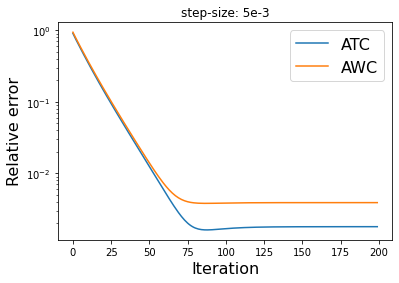

In [26]:
rel_error_dict = sio.loadmat('results/DGD_limitBias.mat')

for method in ['ATC', 'AWC']:
    record = rel_error_dict[method].reshape(-1)
    plt.semilogy(record)
    
plt.legend(['ATC', 'AWC'], fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)
plt.title('step-size: 5e-3')

dirname = 'images'
if not os.path.exists(dirname):
    os.makedirs(dirname)
plt.savefig(os.path.join(dirname, 'DGD_limitBias.png'))

It is observed in the above figure that with the same step-size, ATC can converge to a better solution than AWC.

### 2.5.2 Compare stability range

In [27]:
! bfrun -np $NUM_PROC python DGD_stability.py

[Distributed Grad Descent] Rank 0: global gradient norm: 3.7252473072675936e-13

Running ATC:
Progress 0/200
Progress 100/200

Running AWC:
Progress 0/200
Progress 100/200


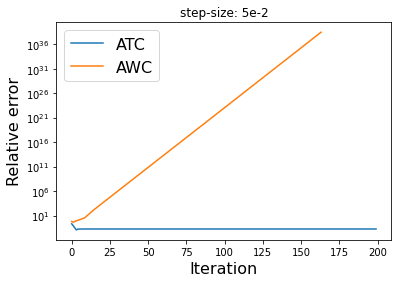

In [28]:
rel_error_dict = sio.loadmat('results/DGD_stability.mat')

for method in ['ATC', 'AWC']:
    record = rel_error_dict[method].reshape(-1)
    plt.semilogy(record)
    
plt.legend(['ATC', 'AWC'], fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)
plt.title('step-size: 5e-2')

dirname = 'images'
if not os.path.exists(dirname):
    os.makedirs(dirname)
plt.savefig(os.path.join(dirname, 'DGD_stability.png'))

When we enlarge the step-size, it is observed that AWC diverges while ATC can still converge

### 2.5.3 Compare communication and computation overlapping

Computation is mainly executed in the CPUs or GPUs, while communication depends on the network situation, other machine's or core's response, etc.
In other words, they are using complete different resources, which is perfect for overlapping. If it is doing properly, it can save use lots of time.
Adapt-With-Combination is one typical example that can overlap the communication and computation naturally.

To achieve than you need to call the nonblocking version functions, for example:

``` python
def AWC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    grad_local = A.t().mm(A.mm(x) - b)                       # compute local grad
    x_new = bf.neighbor_allreduce(x) - alpha*grad_local      # AWC update

def NonBlocking_AWC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    x_handle = bf.neighbor_allreduce_nonblocking(x)          # Nonblocking function returns handle instead of tensor.
    grad_local = A.t().mm(A.mm(x) - b)                       # compute local grad
    x_new = bf.wait(x_handle) - alpha*grad_local             # AWC update. Note calling `wait` on the handle.
```


In [34]:
! bfrun -np $NUM_PROC python NonBlocking.py


Running ATC:
Progress 0/1000
Progress 200/1000
Progress 400/1000
Progress 600/1000
Progress 800/1000
ATC finishes in 3.258173704147339 seconds.

Running AWC:
Progress 0/1000
Progress 200/1000
Progress 400/1000
Progress 600/1000
Progress 800/1000
AWC finishes in 3.0531022548675537 seconds.

Running NBK-AWC:
Progress 0/1000
Progress 200/1000
Progress 400/1000
Progress 600/1000
Progress 800/1000
NBK-AWC finishes in 1.9056735038757324 seconds.


It is observed that Nonblocking-AWC has the shortest time to finish $1000$ iterations through overlapping of communication and computation.

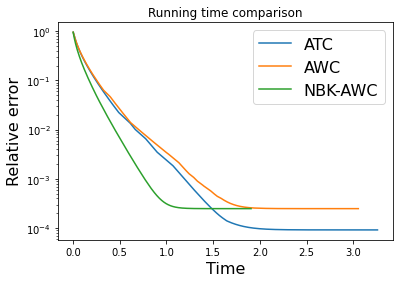

In [35]:
rel_error_dict = sio.loadmat('results/NonBlocking.mat')
for method in ['ATC', 'AWC', 'NBK-AWC']:
    record = rel_error_dict[method].reshape(-1)
    time = rel_error_dict[method+"_time"].reshape(-1)
    plt.semilogy(time, record)
    
plt.legend(['ATC', 'AWC', 'NBK-AWC'], fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Relative error', fontsize=16)
plt.title('Running time comparison')

dirname = 'images'
if not os.path.exists(dirname):
    os.makedirs(dirname)
plt.savefig(os.path.join(dirname, 'NonBlockingTime.png'))